In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CelebA
from torchvision.transforms.v2 import (
    CenterCrop,
    ColorJitter,
    Compose,
    RandomHorizontalFlip,
    ToDtype,
    ToImage,
)
import os

# -------------------------------
# 1. Data Preparation
# -------------------------------

# Set image datatype and dataset path
DTYPE = torch.float32
data_path = "C:/Users/manju/Desktop/ECSE 552/Project"

# Define training and evaluation transforms
train_transform = Compose([
    CenterCrop(178),
    ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    RandomHorizontalFlip(),
    ToImage(),
    ToDtype(dtype=DTYPE, scale=True),
])
normal_transform = Compose([
    CenterCrop(178),
    ToImage(),
    ToDtype(dtype=DTYPE, scale=True)
])

# Load CelebA dataset splits
train_dataset = CelebA(root=data_path, split="train", transform=train_transform)
val_dataset   = CelebA(root=data_path, split="valid", transform=normal_transform)
test_dataset  = CelebA(root=data_path, split="test", transform=normal_transform)

# For quick experimentation, use a subset of each dataset
subset_train = Subset(train_dataset, indices=range(3000))
subset_val   = Subset(val_dataset, indices=range(600))
subset_test  = Subset(test_dataset, indices=range(600))

# Create DataLoaders
train_loader = DataLoader(subset_train, batch_size=32, shuffle=True)
val_loader   = DataLoader(subset_val, batch_size=32, shuffle=False)
test_loader  = DataLoader(subset_test, batch_size=32, shuffle=False)

# Get attribute names (excluding the identifier attribute if present)
ATTRIBUTES = train_dataset.attr_names[:-1]
print(f"Train samples: {len(subset_train)}, Val samples: {len(subset_val)}, Test samples: {len(subset_test)}")
print(f"Number of attributes: {len(ATTRIBUTES)}")
sample_img, _ = train_dataset[0]
print(f"Image resolution: {sample_img.shape[1]}x{sample_img.shape[2]}")

Train samples: 3000, Val samples: 600, Test samples: 600
Number of attributes: 40
Image resolution: 178x178


In [2]:
import numpy as np

def count_attributes(dataset):
    # Get the attribute matrix (each row is a sample, each column is an attribute)
    attr_matrix = np.stack([dataset.dataset.attr[i].numpy() for i in dataset.indices])
    
    # Convert -1 to 0 (CelebA uses -1 for "not present", 1 for "present")
    attr_matrix = (attr_matrix == 1).astype(int)
    
    # Count how many 1s and 0s per attribute
    ones_count = attr_matrix.sum(axis=0)
    zeros_count = attr_matrix.shape[0] - ones_count
    
    return ones_count, zeros_count

# Count for train, val, test subsets
train_ones, train_zeros = count_attributes(subset_train)
val_ones, val_zeros = count_attributes(subset_val)
test_ones, test_zeros = count_attributes(subset_test)

# Print nicely
print("\nAttribute Balancing (Train Set):")
for i, attr_name in enumerate(ATTRIBUTES):
    print(f"{attr_name}: 1s = {train_ones[i]}, 0s = {train_zeros[i]}")



Attribute Balancing (Train Set):
5_o_Clock_Shadow: 1s = 336, 0s = 2664
Arched_Eyebrows: 1s = 824, 0s = 2176
Attractive: 1s = 1550, 0s = 1450
Bags_Under_Eyes: 1s = 628, 0s = 2372
Bald: 1s = 77, 0s = 2923
Bangs: 1s = 459, 0s = 2541
Big_Lips: 1s = 734, 0s = 2266
Big_Nose: 1s = 729, 0s = 2271
Black_Hair: 1s = 718, 0s = 2282
Blond_Hair: 1s = 435, 0s = 2565
Blurry: 1s = 161, 0s = 2839
Brown_Hair: 1s = 618, 0s = 2382
Bushy_Eyebrows: 1s = 434, 0s = 2566
Chubby: 1s = 164, 0s = 2836
Double_Chin: 1s = 121, 0s = 2879
Eyeglasses: 1s = 195, 0s = 2805
Goatee: 1s = 182, 0s = 2818
Gray_Hair: 1s = 152, 0s = 2848
Heavy_Makeup: 1s = 1164, 0s = 1836
High_Cheekbones: 1s = 1333, 0s = 1667
Male: 1s = 1255, 0s = 1745
Mouth_Slightly_Open: 1s = 1432, 0s = 1568
Mustache: 1s = 109, 0s = 2891
Narrow_Eyes: 1s = 368, 0s = 2632
No_Beard: 1s = 2500, 0s = 500
Oval_Face: 1s = 789, 0s = 2211
Pale_Skin: 1s = 130, 0s = 2870
Pointy_Nose: 1s = 832, 0s = 2168
Receding_Hairline: 1s = 222, 0s = 2778
Rosy_Cheeks: 1s = 195, 0s = 

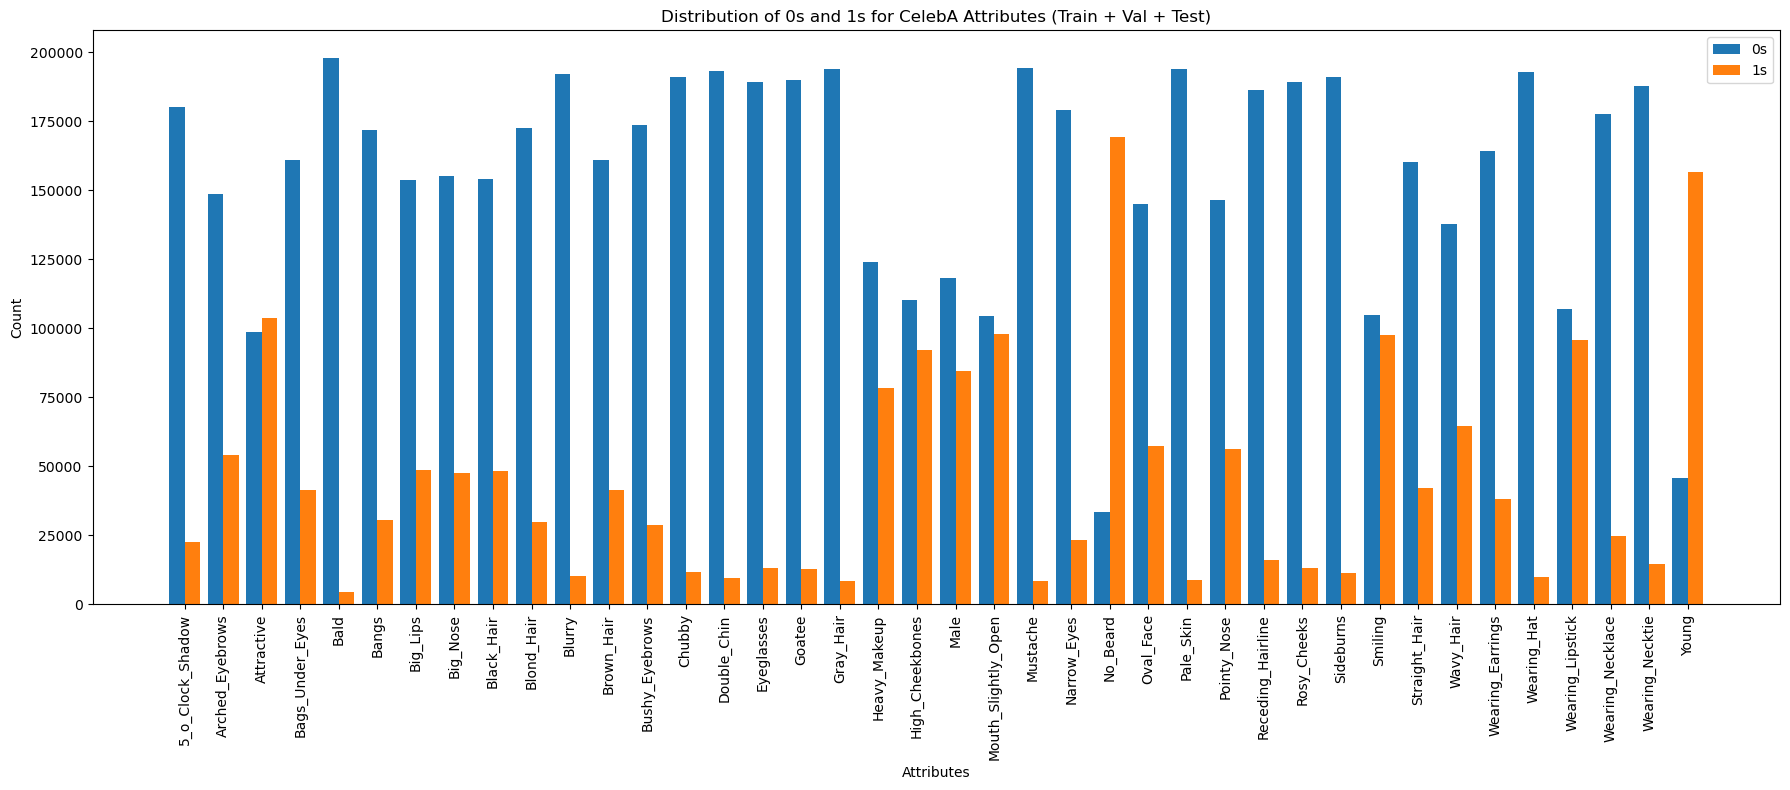

In [5]:
# Function to convert -1/1 to 0/1 and stack attributes
import matplotlib.pyplot as plt
def get_attr_matrix(dataset):
    attr_matrix = np.stack([dataset.attr[i].numpy() for i in range(len(dataset))])
    attr_matrix = (attr_matrix == 1).astype(int)
    return attr_matrix

# Load CelebA splits (no transforms needed for attribute counting)
train_dataset = CelebA(root=data_path, split="train", target_type="attr", download=False)
val_dataset   = CelebA(root=data_path, split="valid", target_type="attr", download=False)
test_dataset  = CelebA(root=data_path, split="test",  target_type="attr", download=False)

# Get attributes and names
ATTRIBUTES = train_dataset.attr_names  # All 40 attributes

# Stack all attributes together
train_attrs = get_attr_matrix(train_dataset)
val_attrs   = get_attr_matrix(val_dataset)
test_attrs  = get_attr_matrix(test_dataset)
ATTRIBUTES = ATTRIBUTES[:40]
all_attrs = np.concatenate([train_attrs, val_attrs, test_attrs], axis=0)

# Count 1s and 0s
ones_count = all_attrs.sum(axis=0)
zeros_count = all_attrs.shape[0] - ones_count

# Visualization
x = np.arange(len(ATTRIBUTES))
width = 0.4

plt.figure(figsize=(18, 8))
plt.bar(x - width/2, zeros_count, width, label='0s')
plt.bar(x + width/2, ones_count, width, label='1s')
plt.xlabel('Attributes')
plt.ylabel('Count')
plt.title('Distribution of 0s and 1s for CelebA Attributes (Train + Val + Test)')
plt.xticks(x, ATTRIBUTES, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

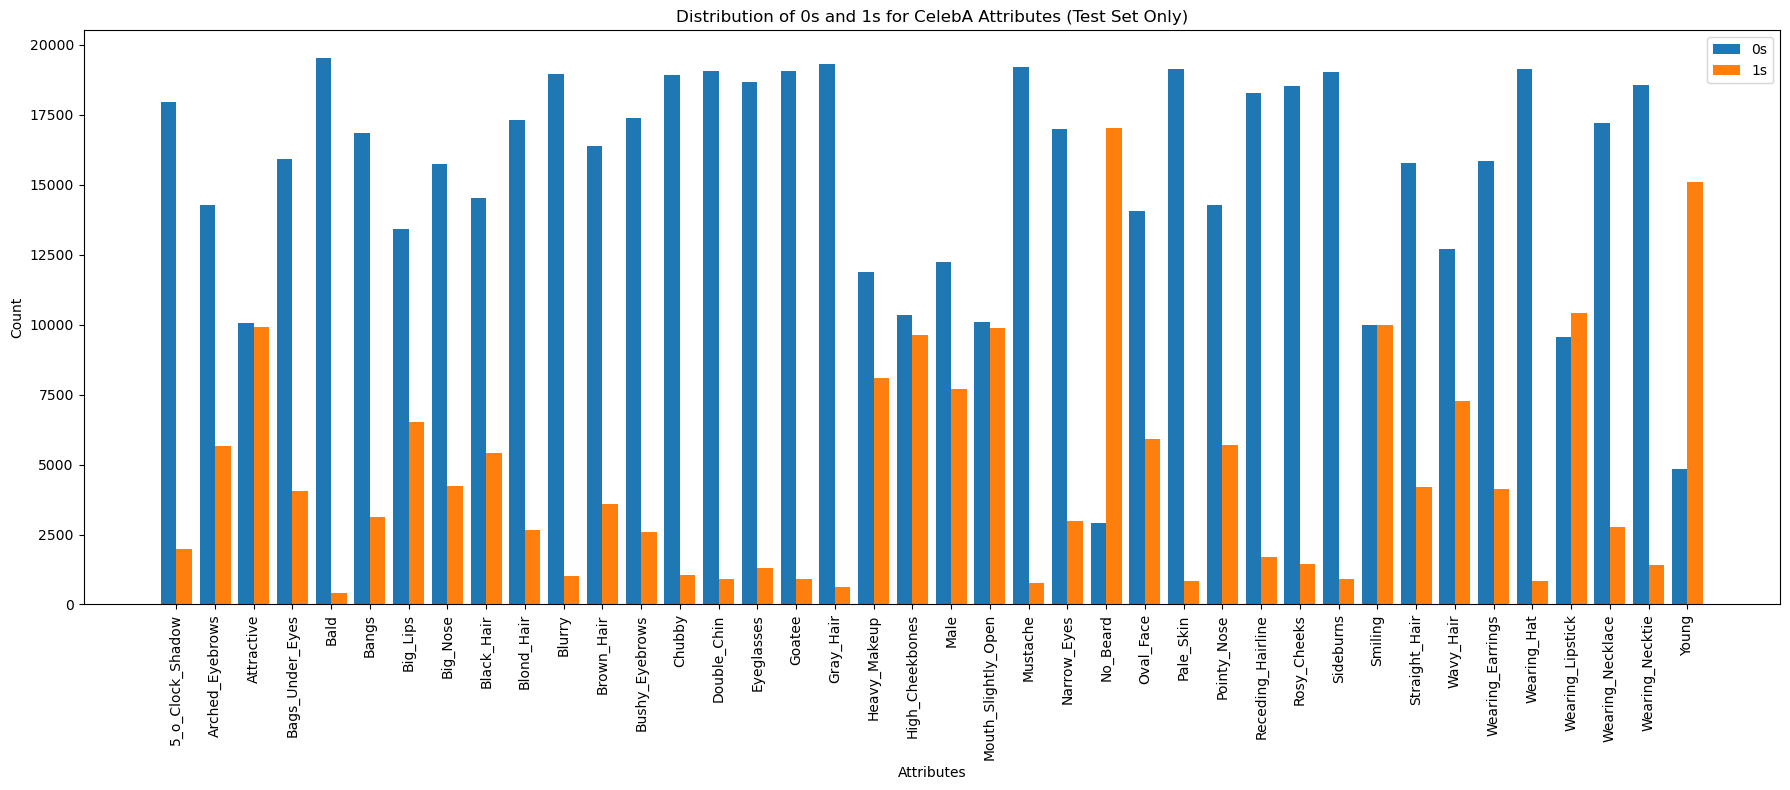

In [6]:


# Get attribute names — ensure exactly 40
ATTRIBUTES = test_dataset.attr_names
if len(ATTRIBUTES) > 40:
    ATTRIBUTES = ATTRIBUTES[:40]

# Get test attribute matrix (only 40 attributes)
test_attrs = get_attr_matrix(test_dataset)[:, :40]

# Count 1s and 0s
ones_count = test_attrs.sum(axis=0)
zeros_count = test_attrs.shape[0] - ones_count

# Visualization
x = np.arange(len(ATTRIBUTES))
width = 0.4

plt.figure(figsize=(18, 8))
plt.bar(x - width/2, zeros_count, width, label='0s')
plt.bar(x + width/2, ones_count, width, label='1s')
plt.xlabel('Attributes')
plt.ylabel('Count')
plt.title('Distribution of 0s and 1s for CelebA Attributes (Test Set Only)')
plt.xticks(x, ATTRIBUTES, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


In [7]:

class CNNBackbone(nn.Module):
    def __init__(self):
        super(CNNBackbone, self).__init__()
        # Define a simple CNN architecture.
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # [B, 32, 178, 178]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 32, 89, 89]

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # [B, 64, 89, 89]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 64, 44, 44]

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # [B, 128, 44, 44]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 128, 22, 22]

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # [B, 256, 22, 22]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # [B, 256, 11, 11]
        )
        # Adaptive average pooling to obtain a fixed-size feature map.
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer to map to the desired feature dimension.
        self.fc = nn.Linear(256, 512)  # Output dimension for MMOE input.
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.avgpool(x)         # [B, 256, 1, 1]
        x = torch.flatten(x, 1)     # [B, 256]
        x = self.fc(x)              # [B, 512]
        return x

# -------------------------------
# 3. MMOE Model with Attention and BatchNorm
# -------------------------------

# Modify the Attention module so that the query layer accepts input features of dimension query_dim.
class Attention(nn.Module):
    def __init__(self, query_dim, expert_dim):
        super(Attention, self).__init__()
        self.query = nn.Linear(query_dim, expert_dim)
        self.key = nn.Linear(expert_dim, expert_dim)
        self.value = nn.Linear(expert_dim, expert_dim)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, expert_outputs, x):
        # expert_outputs: [B, num_experts, expert_dim]
        # x: shared feature vector [B, query_dim]
        q = self.query(x).unsqueeze(1)            # [B, 1, expert_dim]
        keys = self.key(expert_outputs)           # [B, num_experts, expert_dim]
        values = self.value(expert_outputs)       # [B, num_experts, expert_dim]
        scores = torch.bmm(q, keys.transpose(1, 2))  # [B, 1, num_experts]
        attn_weights = self.softmax(scores)
        attn_output = torch.bmm(attn_weights, values)  # [B, 1, expert_dim]
        return attn_output.squeeze(1)             # [B, expert_dim]

class Expert(nn.Module):
    def __init__(self, input_dim, expert_dim):
        super(Expert, self).__init__()
        self.fc = nn.Linear(input_dim, expert_dim)
        self.bn = nn.BatchNorm1d(expert_dim)
    
    def forward(self, x):
        out = self.fc(x)
        out = self.bn(out)
        return F.relu(out)

class Gate(nn.Module):
    def __init__(self, input_dim, num_experts):
        super(Gate, self).__init__()
        self.fc = nn.Linear(input_dim, num_experts)
    
    def forward(self, x):
        gate_scores = self.fc(x)
        return F.softmax(gate_scores, dim=1)

class TaskTower(nn.Module):
    def __init__(self, expert_dim):
        super(TaskTower, self).__init__()
        self.fc = nn.Linear(expert_dim, 1)
    
    def forward(self, x):
        return self.fc(x)

class MMOE(nn.Module):
    def __init__(self, input_dim, expert_dim, num_experts, num_tasks):
        super(MMOE, self).__init__()
        self.num_experts = num_experts
        self.num_tasks = num_tasks
        
        # Experts with BatchNorm
        self.experts = nn.ModuleList([Expert(input_dim, expert_dim) for _ in range(num_experts)])
        # Gating network for each task
        self.gates = nn.ModuleList([Gate(input_dim, num_experts) for _ in range(num_tasks)])
        # Task-specific towers
        self.task_towers = nn.ModuleList([TaskTower(expert_dim) for _ in range(num_tasks)])
        # Shared attention module; note that the query input comes from the backbone (input_dim)
        self.attention = Attention(query_dim=input_dim, expert_dim=expert_dim)
    
    def forward(self, x):
        # x: [B, input_dim]
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)  # [B, num_experts, expert_dim]
        task_outputs = []
        for gate, tower in zip(self.gates, self.task_towers):
            gate_weights = gate(x).unsqueeze(-1)           # [B, num_experts, 1]
            gated_output = torch.sum(gate_weights * expert_outputs, dim=1)  # [B, expert_dim]
            attn_output = self.attention(expert_outputs, x)  # [B, expert_dim]
            combined_feature = gated_output + attn_output
            task_outputs.append(tower(combined_feature))
        return task_outputs

In [8]:

# -------------------------------
# 4. Model Instantiation
# -------------------------------

# Define dimensions and instantiate models.
input_dim = 512    # Our CNNBackbone outputs a 512-dim feature vector.
expert_dim = 128
num_experts = 6
num_tasks = len(ATTRIBUTES)

# Instantiate the untrained CNN backbone and MMOE model.
backbone = CNNBackbone()
mmoe_model = MMOE(input_dim, expert_dim, num_experts, num_tasks)

# Move models to device.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
backbone.to(device)
mmoe_model.to(device)

MMOE(
  (experts): ModuleList(
    (0-5): 6 x Expert(
      (fc): Linear(in_features=512, out_features=128, bias=True)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (gates): ModuleList(
    (0-39): 40 x Gate(
      (fc): Linear(in_features=512, out_features=6, bias=True)
    )
  )
  (task_towers): ModuleList(
    (0-39): 40 x TaskTower(
      (fc): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (attention): Attention(
    (query): Linear(in_features=512, out_features=128, bias=True)
    (key): Linear(in_features=128, out_features=128, bias=True)
    (value): Linear(in_features=128, out_features=128, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(list(backbone.parameters()) + list(mmoe_model.parameters()), lr=1e-4)
num_epochs = 20

# Early stopping parameters
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait for improvement
patience_counter = 0
best_model_path = "best_model.pt"

# Lists to store predictions and labels for each epoch.
all_train_preds = []
all_train_labels = []
all_test_preds = []
all_test_labels = []

for epoch in range(num_epochs):
    # ---- Training Phase ----
    backbone.train()
    mmoe_model.train()
    train_preds = []
    train_labels = []
    epoch_train_loss = 0.0
    num_train_batches = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()  # Binary labels per task
        
        # Forward pass: extract features and pass through MMOE.
        features = backbone(images)   # [B, 512]
        outputs = mmoe_model(features)  # List of tensors, each [B, 1]
        
        # Compute loss across all tasks.
        loss = 0.0
        for i, task_output in enumerate(outputs):
            loss += criterion(task_output.squeeze(), labels[:, i])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        num_train_batches += 1
        
        # Save predictions and labels for this batch.
        with torch.no_grad():
            batch_preds = []
            for task_output in outputs:
                # Convert logits to probabilities.
                pred = torch.sigmoid(task_output)
                batch_preds.append(pred.unsqueeze(1))  # [B, 1]
            batch_preds = torch.cat(batch_preds, dim=1)  # [B, num_tasks]
            train_preds.append(batch_preds.cpu())
            train_labels.append(labels.cpu())
    
    avg_train_loss = epoch_train_loss / num_train_batches
    train_preds = torch.cat(train_preds, dim=0)
    train_labels = torch.cat(train_labels, dim=0)
    all_train_preds.append(train_preds)
    all_train_labels.append(train_labels)
    print(f"Epoch {epoch+1}/{num_epochs}: Training complete. Avg Loss: {avg_train_loss:.4f}")
    
    # ---- Validation Phase ----
    backbone.eval()
    mmoe_model.eval()
    val_preds = []
    val_labels = []
    epoch_val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            
            features = backbone(images)
            outputs = mmoe_model(features)
            
            loss_val = 0.0
            for i, task_output in enumerate(outputs):
                loss_val += criterion(task_output.squeeze(), labels[:, i])
            epoch_val_loss += loss_val.item()
            num_val_batches += 1
            
            batch_preds = []
            for task_output in outputs:
                pred = torch.sigmoid(task_output)
                batch_preds.append(pred.unsqueeze(1))
            batch_preds = torch.cat(batch_preds, dim=1)
            val_preds.append(batch_preds.cpu())
            val_labels.append(labels.cpu())
    
    avg_val_loss = epoch_val_loss / num_val_batches
    val_preds = torch.cat(val_preds, dim=0)
    val_labels = torch.cat(val_labels, dim=0)
    all_test_preds.append(val_preds)
    all_test_labels.append(val_labels)
    print(f"Epoch {epoch+1}/{num_epochs}: Validation complete. Avg Loss: {avg_val_loss:.4f}")
    
    # ---- Save Best Model and Early Stopping Check ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'backbone_state_dict': backbone.state_dict(),
            'mmoe_state_dict': mmoe_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': best_val_loss,
        }, best_model_path)
        print(f"Epoch {epoch+1}: New best model saved with val loss {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"Epoch {epoch+1}: No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break


Epoch 1/20: Training complete. Avg Loss: 20.8204
Epoch 1/20: Validation complete. Avg Loss: 18.0020
Epoch 1: New best model saved with val loss 18.0020
Epoch 2/20: Training complete. Avg Loss: 17.0690
Epoch 2/20: Validation complete. Avg Loss: 17.0247
Epoch 2: New best model saved with val loss 17.0247
Epoch 3/20: Training complete. Avg Loss: 16.0871
Epoch 3/20: Validation complete. Avg Loss: 17.5615
Epoch 3: No improvement. Patience: 1/3
Epoch 4/20: Training complete. Avg Loss: 15.5104
Epoch 4/20: Validation complete. Avg Loss: 15.8752
Epoch 4: New best model saved with val loss 15.8752
Epoch 5/20: Training complete. Avg Loss: 15.1042
Epoch 5/20: Validation complete. Avg Loss: 16.1260
Epoch 5: No improvement. Patience: 1/3
Epoch 6/20: Training complete. Avg Loss: 14.7315
Epoch 6/20: Validation complete. Avg Loss: 15.2298
Epoch 6: New best model saved with val loss 15.2298
Epoch 7/20: Training complete. Avg Loss: 14.3695
Epoch 7/20: Validation complete. Avg Loss: 14.7614
Epoch 7: New b

In [10]:
# -------------------------------
# 6. Test Phase: Load Best Model and Calculate Accuracy
# -------------------------------

# Load the best model saved during training.
checkpoint = torch.load(best_model_path)
backbone.load_state_dict(checkpoint['backbone_state_dict'])
mmoe_model.load_state_dict(checkpoint['mmoe_state_dict'])
backbone.eval()
mmoe_model.eval()

total_correct = 0
total_samples = 0
# Initialize per-task counters.
task_correct = [0] * num_tasks
task_total = [0] * num_tasks

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        # Ensure labels are float (binary) for comparison.
        labels = labels.to(device).float()
        
        features = backbone(images)
        outputs = mmoe_model(features)
        
        # Convert each task's output to binary predictions (threshold = 0.5)
        batch_preds = []
        for task_output in outputs:
            preds = (torch.sigmoid(task_output) > 0.5).float()  # [B, 1]
            batch_preds.append(preds)
        # Concatenate predictions for all tasks: shape [B, num_tasks]
        batch_preds = torch.cat(batch_preds, dim=1)
        
        # Compute overall accuracy.
        total_correct += (batch_preds == labels).sum().item()
        total_samples += labels.numel()
        
        # Compute per-task accuracy.
        for i in range(num_tasks):
            task_correct[i] += (batch_preds[:, i] == labels[:, i]).sum().item()
            task_total[i] += labels.size(0)

overall_accuracy = total_correct / total_samples
print(f"Overall Test Accuracy: {overall_accuracy * 100:.2f}%")

for i in range(num_tasks):
    task_accuracy = task_correct[i] / task_total[i]
    print(f"Task {i+1} Accuracy: {task_accuracy * 100:.2f}%")


Overall Test Accuracy: 83.27%
Task 1 Accuracy: 88.17%
Task 2 Accuracy: 71.33%
Task 3 Accuracy: 71.67%
Task 4 Accuracy: 80.33%
Task 5 Accuracy: 97.67%
Task 6 Accuracy: 84.00%
Task 7 Accuracy: 68.17%
Task 8 Accuracy: 77.50%
Task 9 Accuracy: 71.83%
Task 10 Accuracy: 88.33%
Task 11 Accuracy: 94.67%
Task 12 Accuracy: 83.17%
Task 13 Accuracy: 88.00%
Task 14 Accuracy: 93.00%
Task 15 Accuracy: 95.00%
Task 16 Accuracy: 92.67%
Task 17 Accuracy: 95.83%
Task 18 Accuracy: 97.00%
Task 19 Accuracy: 78.00%
Task 20 Accuracy: 62.33%
Task 21 Accuracy: 79.00%
Task 22 Accuracy: 58.00%
Task 23 Accuracy: 96.33%
Task 24 Accuracy: 85.67%
Task 25 Accuracy: 84.83%
Task 26 Accuracy: 71.33%
Task 27 Accuracy: 96.83%
Task 28 Accuracy: 73.50%
Task 29 Accuracy: 91.67%
Task 30 Accuracy: 91.50%
Task 31 Accuracy: 96.33%
Task 32 Accuracy: 64.33%
Task 33 Accuracy: 79.17%
Task 34 Accuracy: 73.17%
Task 35 Accuracy: 79.83%
Task 36 Accuracy: 94.67%
Task 37 Accuracy: 77.50%
Task 38 Accuracy: 87.50%
Task 39 Accuracy: 94.17%
Task

In [12]:
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import CelebA

def evaluate(backbone, mmoe_model, dataloader, device):
    backbone.eval()
    mmoe_model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device).float()
            
            # Pass through the backbone and then the MMOE model.
            features = backbone(x)  # [B, 512]
            outputs = mmoe_model(features)  # List of tensors, each [B, 1]
            
            # Concatenate outputs from each task along dimension 1: [B, num_tasks]
            logits = torch.cat(outputs, dim=1)
            probs = torch.sigmoid(logits)
            pred_binary = (probs > 0.5).float()
            
            all_preds.append(pred_binary.cpu().numpy())
            all_labels.append(y.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    return all_preds, all_labels

# Example usage:
# Define your test dataset using the normal transform.
test_set = CelebA(
    root=data_path,
    split="test",
    transform=normal_transform,
    download=False
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the combined model (backbone and MMOE).
all_preds, all_labels = evaluate(backbone, mmoe_model, test_loader, device)


In [13]:
import numpy as np
import pandas as pd
def save_preds_labels_to_csv(all_preds, all_labels, filename="results.csv", attributes=None):
    """
    Save predictions and labels to a CSV file side-by-side.
    If attribute names are given, use them as column headers.
    """
    # Make sure arrays are numpy
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Prefix column names
    if attributes is None:
        attributes = [f"attr_{i}" for i in range(all_preds.shape[1])]

    pred_cols = [f"pred_{attr}" for attr in attributes]
    label_cols = [f"true_{attr}" for attr in attributes]

    df_preds = pd.DataFrame(all_preds, columns=pred_cols)
    df_labels = pd.DataFrame(all_labels, columns=label_cols)

    df = pd.concat([df_preds, df_labels], axis=1)
    df.to_csv(filename, index=False)
    print(f"✅ Saved predictions and labels to {filename}")



save_preds_labels_to_csv(all_preds, all_labels, filename="mmoe_test_results.csv", attributes=ATTRIBUTES)

✅ Saved predictions and labels to mmoe_test_results.csv
